In [1]:
!pip3 install levenshtein
!pip3 install networkx

In [2]:
import os
import sys

current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..', 'src')
sys.path.append(src_dir)

In [3]:
import re
import pandas as pd
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt 

from dqc.dqc import DataQualityPipeline
from etl.etl import ETL, RelationsTransform
from etl.src.kaggle_data_loader import download_data
from Levenshtein import distance

In [4]:
download_data()

data_paths = {}

for dirname, _, filenames in os.walk(f'{src_dir}/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        data_paths[filename] = f"{dirname}/{filename}"

relations = {}

for file, path in data_paths.items():
    relations[file.split('.')[0]] = pd.read_csv(path)

/home/sandra/Projects/ds_practice/notebooks/../src/data/sales_train.csv
/home/sandra/Projects/ds_practice/notebooks/../src/data/item_categories.csv
/home/sandra/Projects/ds_practice/notebooks/../src/data/sample_submission.csv
/home/sandra/Projects/ds_practice/notebooks/../src/data/items.csv
/home/sandra/Projects/ds_practice/notebooks/../src/data/test.csv
/home/sandra/Projects/ds_practice/notebooks/../src/data/shops.csv


## I. Data quality check:
1. Identify the data sources and gather the data
2. Check for missing values, duplicates, and outliers
3. Check for inconsistencies in data types and formats
4. Validate the data against business rules and requirements
5. Identify any data quality issues and document them
6. Determine whether to clean, transform, or discard the data

In [5]:
report = DataQualityPipeline()(relations)

In [6]:
relations.keys()

dict_keys(['sales_train', 'item_categories', 'sample_submission', 'items', 'test', 'shops'])

In [46]:
report["validation report"]['values']

nan_report  unique    dtype    total
table_name        column_name                                            
item_categories   item_category_name        0.0      84   object       84
                  item_category_id          0.0      84    int64       84
items             item_category_id          0.0      84    int64    22170
                  item_id                   0.0   22170    int64    22170
                  item_name                 0.0   22170   object    22170
sales_train       date                      0.0    1034   object  2935849
                  date_block_num            0.0      34    int64  2935849
                  shop_id                   0.0      60    int64  2935849
                  item_id                   0.0   21807    int64  2935849
                  item_price                0.0   19993  float64  2935849
                  item_cnt_day              0.0     198  float64  2935849
sample_submission ID                        0.0  214200    int64   214200
                  item_cnt_month            0.0       1  float64   214200
shops             shop_name                 0.0      60   object       60
                  shop_id                   0.0      60    int64       60
test              ID                        0.0  214200    int64   214200
                  shop_id                   0.0      42    int64   214200
                  item_id                   0.0    5100    int64   214200

* item_cnt_month not informative, 1 unique value
* item_category_id and shop_id have average cardinality (84, 60)
* item_id have high cardinality (22170) and should be processed

In [47]:
report["validation report"]['duplicates']

,duplicates
item_categories,0
items,0
sales_train,6
sample_submission,0
shops,0
test,0


In [48]:
report["validation report"]['sparcity']

,left_only,intersect,right_only
"sales_train, items ON item_id",0,21807,363
"sales_train, test ON item_id",17070,4737,363
"sales_train, test ON shop_id",18,42,0
"sales_train, shops ON shop_id",0,60,0
"item_categories, items ON item_category_id",0,84,0
"sample_submission, test ON ID",0,214200,0
"items, test ON item_id",17070,5100,0
"test, shops ON shop_id",0,42,18


* sales_train and test sets contain 
item_ids which not represented in each other => for some item_ids we don't know price

* on the contrary, shop_ids in test all represented in sales_train

In [49]:
report["statistical report"]['distribution']

,count,mean,std,min,1%,25%,50%,75%,99%,max
item_price,2935849.0,890.853233,1729.799631,-1.0,5.0,249.0,399.0,999.0,5999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,1.0,5.0,2169.0
item_cnt_month,214200.0,0.500000,0.000000,0.5,0.5,0.5,0.5,0.5,0.5,0.5


* item_price and item_cnt_day contain negative values and outliers
* item_price obviosly can't be negative

In [50]:
report["statistical report"]['outliers']

,1% left range,98% middle range,1% right range
item_price,6.0,5994.0,301981.0
item_cnt_day,23.0,4.0,2164.0
item_cnt_month,0.0,0.0,0.0


* oultiers in item_price and item_cnt_day
* as was mentioned, item_cnt_month not informative and can be dropped

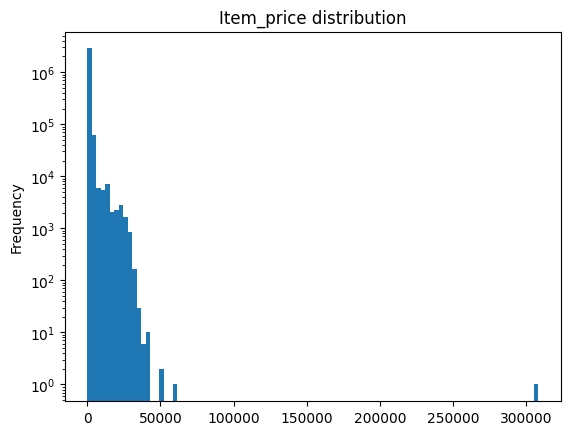

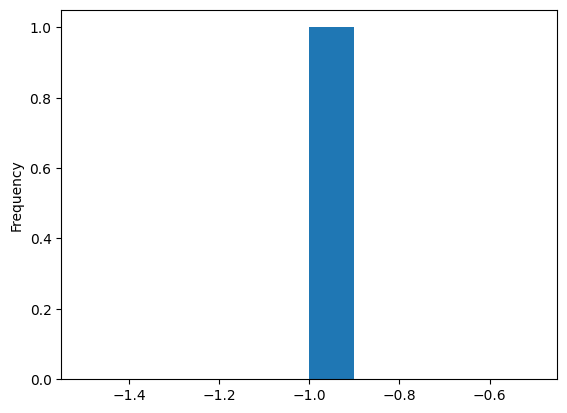

In [51]:
relations["sales_train"]["item_price"].plot.hist(bins=100, logy=True)
plt.title("Item_price distribution")
plt.figure()
relations["sales_train"]["item_price"][relations["sales_train"]["item_price"] < 0].plot.hist();

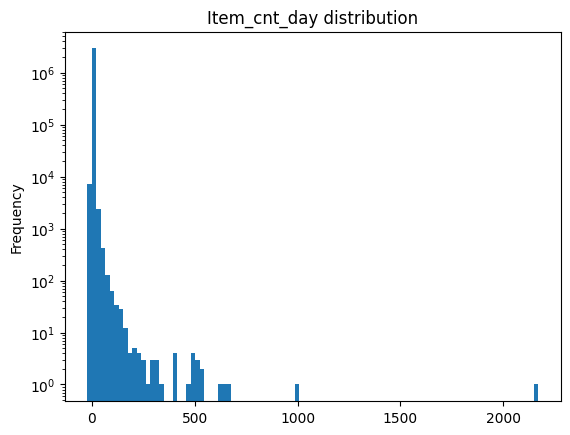

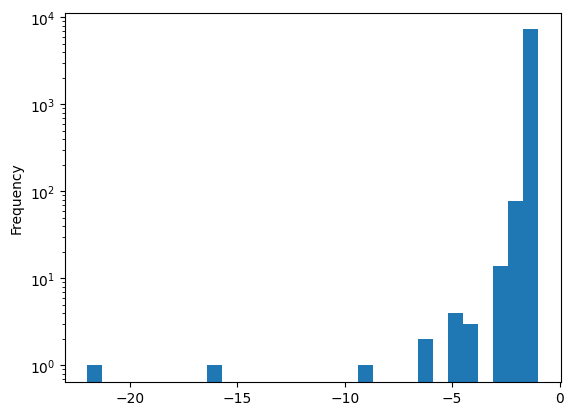

In [52]:
relations["sales_train"]["item_cnt_day"].plot.hist(bins=100, logy=True)
plt.title("Item_cnt_day distribution")
plt.figure()
relations["sales_train"]["item_cnt_day"][relations["sales_train"]["item_cnt_day"] < 0].plot.hist(bins=30, logy=True);

In [53]:
negative_item_price = relations["sales_train"][relations["sales_train"]["item_price"] < 0]
negative_item_price

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


Negative item_cnt_day can be errors, returns or refuses. 
To recognize negative volumes as a return or refuse, we need to see a pre-purchase of this item.

In [63]:
relations["sales_train"].sort_values(by='item_cnt_day', ascending=True).head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1057907,02.11.2013,10,12,8023,15.000000,-22.0
1835454,10.07.2014,18,14,20949,5.000000,-16.0
2048519,10.10.2014,21,12,9242,1433.333333,-9.0
59156,18.01.2013,0,12,1590,2599.000000,-6.0
940092,19.10.2013,9,42,3732,2599.000000,-6.0
2619997,29.05.2015,28,6,4894,3999.000000,-5.0
2458733,18.02.2015,25,2,16790,2899.000000,-5.0
93576,21.01.2013,0,43,20384,1599.000000,-5.0
59155,10.01.2013,0,12,1590,2599.000000,-5.0
222426,22.02.2013,1,28,21323,199.000000,-4.0


correlation:  0.8272851354655943


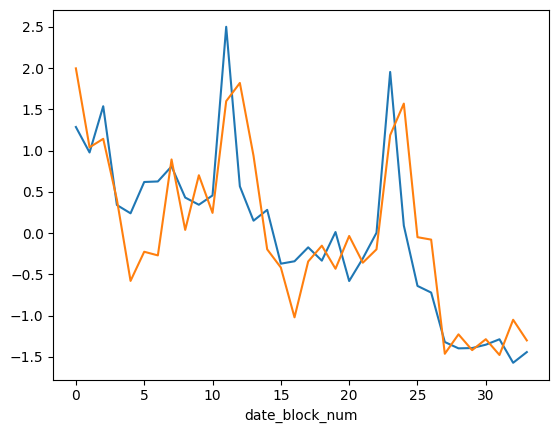

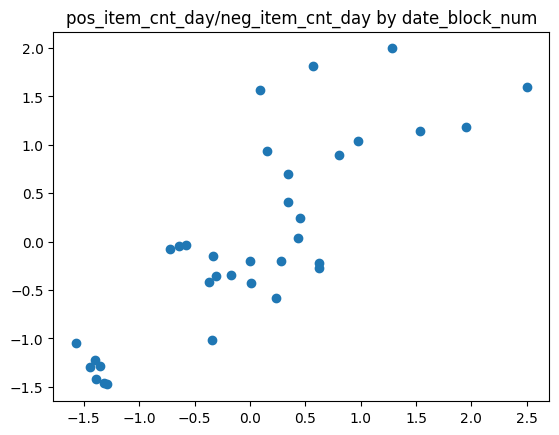

In [55]:
sales_train_cnt = relations["sales_train"][relations["sales_train"]["item_cnt_day"]>0]
sales_train_ncnt = relations["sales_train"][relations["sales_train"]["item_cnt_day"]<0]


normalize = lambda df: (df-df.mean())/df.std()

pos = normalize(sales_train_cnt.groupby("date_block_num").date.count())
neg = normalize(sales_train_ncnt.groupby("date_block_num").date.count())

pos.plot()
neg.plot()

plt.figure()
plt.title("pos_item_cnt_day/neg_item_cnt_day by date_block_num")
plt.scatter(pos, neg)

print("correlation: ", np.corrcoef(pos, neg)[0,1])

Since negative values ​​are highly correlated with purchases, this is very similar to returns. But just on the basis of correlation, we cannot assume that these are returns. Obviously, the number of errors is directly proportional to the use of the database, so the seasonality that determines entries in the database also determines both the number of errors and returns. Most likely there is both. It implicitly assumes that the more time has passed since the purchase, the less likely a return is.


I assume there are two kinds of negative values:

1. Returns
2. Mistakes
3. Replacement

The basic assumptions about the return are:

1. no less quantity
2. same store
3. same price

and some weak assumptions:

4. the more time has passed since the purchase, the less likely it's to be a return
5. the closer the sum between a positive and negative value is to zero, the more likely it is a buy/return pair.

The basic assumptions about the replacement are:

1. same store

Replacements are very ambiguous and hard to distinguish from errors <br>
An error, respectively, is something that is not a return and replacement.

The following is an example of what a return might be:

In [56]:
sales_train = relations["sales_train"].copy()
sales_train["date"] = pd.to_datetime(sales_train["date"], format="%d.%m.%Y")
sales_train[1:3]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1,2013-01-03,0,25,2552,899.0,1.0
2,2013-01-05,0,25,2552,899.0,-1.0


In [57]:
# will be True for item_cnt_day < 0 in the next cell
sales_train["return_candidate"] = [False] * len(sales_train)
sales_train.head(4)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,return_candidate
0,2013-01-02,0,59,22154,999.00,1.0,False
1,2013-01-03,0,25,2552,899.00,1.0,False
2,2013-01-05,0,25,2552,899.00,-1.0,False
3,2013-01-06,0,25,2554,1709.05,1.0,False


Due to the ambiguity of the purchase/return pairs, we cannot define exactly what a return is in the general case.

But we can find data that is obviously not a return. This is data that does not correspond to a previous purchase with the same price in an amount not less than a refund.

In [59]:
from math import e

# example of a function decreasing monotonically with increasing distance and difference
def pair_score(time_dist, val_dist):
    return -time_dist -val_dist

# True for purchase candidates (item_cnt_day > 0) that will be returned (with highest score among other candidates)
# for anything else False (item_cnt_day < 0 or not highest score)
sales_train["will_be_returned"] = len(sales_train) * [False]

pairs = []
for shop_id, shop_group in sales_train.groupby("shop_id"):
    # for one return we can use only one purchase, to monitor purchases that we haven't 
    # assigned to return yet we define "not_used" column
    shop_group["not_used"] = len(shop_group) * [True]

    neg_group = shop_group[shop_group["item_cnt_day"] < 0]
    if neg_group.empty:
        continue

    for neg_sale_id, neg_row in neg_group.iterrows():
        # return candidate
        neg_id = neg_row["item_id"]
        neg_date = neg_row["date"]
        neg_price = neg_row["item_price"]
        neg_item_cnt_day = neg_row["item_cnt_day"]

        purchase_candidates = shop_group[
                                (shop_group["item_id"] == neg_id) & 
                                (shop_group["date"] <= neg_date) &
                                (shop_group["item_price"] == neg_price) & 
                                (shop_group["item_cnt_day"] + neg_item_cnt_day >= 0) &
                                (shop_group["not_used"])
                                ]
        
        if purchase_candidates.empty:
            continue

        vals = []

        names = list(purchase_candidates.index)
        dists = (neg_date - purchase_candidates["date"]).dt.days
        diffs = neg_item_cnt_day + purchase_candidates["item_cnt_day"]

        scores = [(name, pair_score(dist, diff)) for name, dist, diff in zip(names, dists, diffs)]
        # choosing max score for purchase candidate
        max_ = max(scores, key=lambda x: x[1])
        argmax = max_[0]

        purchase = purchase_candidates.loc[argmax]

        shop_group.at[argmax, "not_used"] = False
        sales_train.at[argmax, "will_be_returned"] = True
        sales_train.at[neg_sale_id, "return_candidate"] = True
        pairs.append([purchase, neg_row])

In [60]:
len(pairs)

7126

In [61]:
sales_train[(sales_train["item_cnt_day"] < 0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,return_candidate,will_be_returned
2,2013-01-05,0,25,2552,899.0,-1.0,True,False
148,2013-01-23,0,25,2321,999.0,-1.0,True,False
175,2013-01-07,0,25,2199,1449.0,-1.0,True,False
807,2013-01-02,0,25,2330,599.0,-1.0,False,False
1041,2013-01-13,0,25,5034,1989.0,-1.0,False,False
...,...,...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1.0,True,False
2934462,2015-10-18,33,25,4896,6398.0,-1.0,True,False
2935263,2015-10-05,33,25,10039,249.0,-1.0,True,False
2935643,2015-10-16,33,25,7893,2990.0,-1.0,True,False


In [62]:
sales_train[sales_train["return_candidate"]]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,return_candidate,will_be_returned
2,2013-01-05,0,25,2552,899.0,-1.0,True,False
148,2013-01-23,0,25,2321,999.0,-1.0,True,False
175,2013-01-07,0,25,2199,1449.0,-1.0,True,False
1674,2013-01-07,0,25,4093,899.0,-1.0,True,False
2411,2013-01-14,0,24,1628,3899.0,-1.0,True,False
...,...,...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1.0,True,False
2934462,2015-10-18,33,25,4896,6398.0,-1.0,True,False
2935263,2015-10-05,33,25,10039,249.0,-1.0,True,False
2935643,2015-10-16,33,25,7893,2990.0,-1.0,True,False


According to provided logic we found that there is 230 positions with errors that couldn't be a return

## Item analysis

### Item categories
Seems like some categories can be aggregated if necessary (maybe with some information loss)

In [7]:
relations["item_categories"].head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


<Axes: xlabel='item_category_id'>

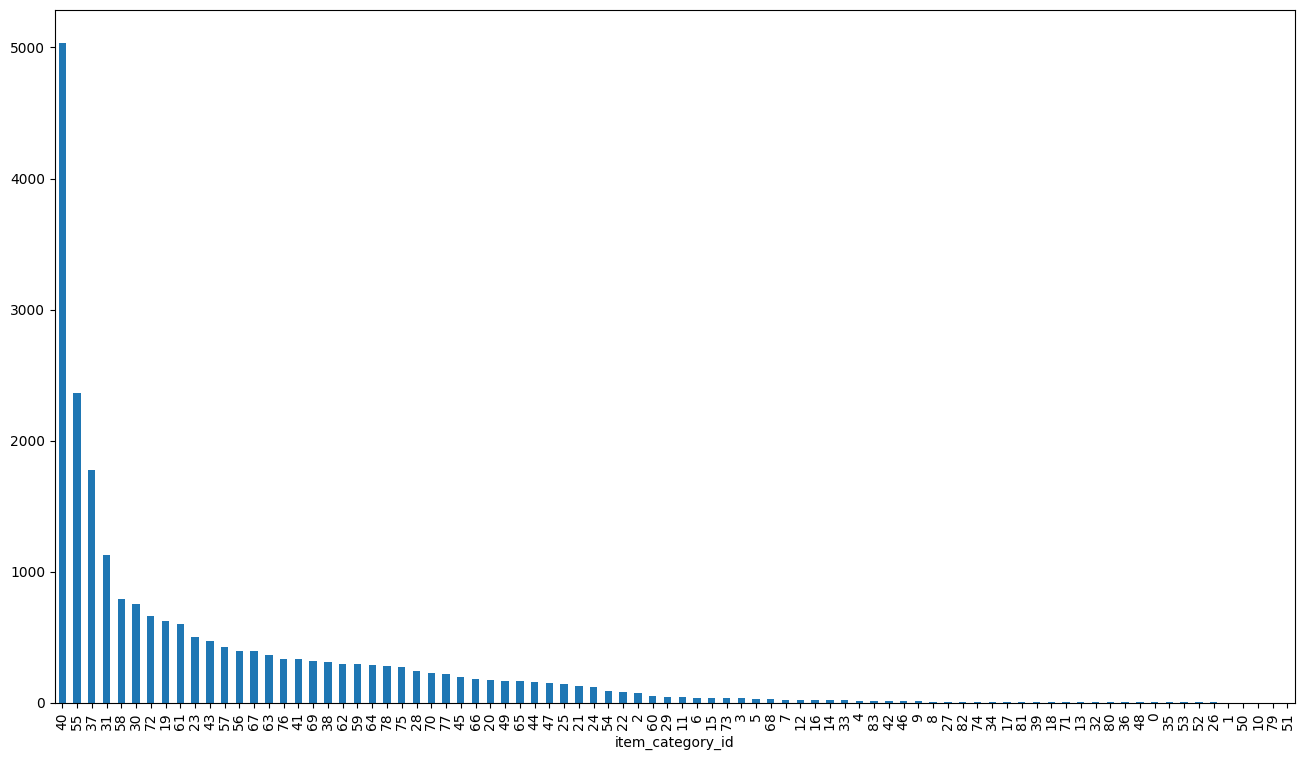

In [8]:
cat_groups = relations['items'].groupby("item_category_id")
cat_groups.count()["item_id"].sort_values(ascending=False).plot.bar(figsize=(16, 9))

### Items processing

We can aggregate similar strings to new classes, but in some cases it can spoile our data:
So we should distinguish 2 approaches:

1. Data cleaning. We use standartization for strings (one case, without special symbols etc.)
2. "Unsafe" aggregations that can spoil our data aggregate semantically different data. But also can be more expressive (high recall, but precision can be lower)

#### Items data cleaning

In [9]:
items = relations["items"].copy()
items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Let's remove uppercase and special symbols from item_name and look at item_name count of values before and after 

In [45]:
items.loc[:, "item_name"] = items["item_name"].str.lower()

com=re.compile(r'[^\w\s]+')
items.loc[:, "item_name"] = [com.sub('',x) for x in items['item_name'].tolist()]

print(f'Item_name count - {len(items["item_name"])}\nUnique item_name count - {len(items["item_name"].unique())}')
items["item_name"].head()

# we have to remove duplicates and change there id's
id_to_name = items.to_dict()["item_name"]
name_to_first_id = items.groupby("item_name").first().to_dict()["item_id"]
ids_to_id = {key: name_to_first_id[id_to_name[key]] for key in id_to_name.keys()}

# removing identity transformations
i = 0
keys = list(ids_to_id.keys())
while i < len(keys):
    if ids_to_id[keys[i]] == keys[i]:
        del ids_to_id[keys[i]]
    i+=1

Item_name count - 22170
Unique item_name count - 22099


#### Item aggregation idea

In [11]:
tr = 2
cat_distance_graphs = {}

for cat, df in relations['items'].groupby("item_category_id"):
    cat_items = df["item_name"]
    distance_matrix = []
    print("cat processing: ", cat)
    for i_item in cat_items:
        r = []
        for j_item in cat_items:
            r.append(distance(i_item, j_item))
        distance_matrix.append(r)
    
    distance_matrix = np.array(distance_matrix)
    adjacency_matrix = pd.DataFrame((distance_matrix <= tr) - np.identity(len(cat_items)), index=cat_items, columns=cat_items)
    labels = cat_items
    
    cat_distance_graphs[cat] = nx.Graph(adjacency_matrix)

cat processing:  0
cat processing:  1
cat processing:  2
cat processing:  3
cat processing:  4
cat processing:  5
cat processing:  6
cat processing:  7
cat processing:  8
cat processing:  9
cat processing:  10
cat processing:  11
cat processing:  12
cat processing:  13
cat processing:  14
cat processing:  15
cat processing:  16
cat processing:  17
cat processing:  18
cat processing:  19
cat processing:  20
cat processing:  21
cat processing:  22
cat processing:  23
cat processing:  24
cat processing:  25
cat processing:  26
cat processing:  27
cat processing:  28
cat processing:  29
cat processing:  30
cat processing:  31
cat processing:  32
cat processing:  33
cat processing:  34
cat processing:  35
cat processing:  36
cat processing:  37
cat processing:  38
cat processing:  39
cat processing:  40
cat processing:  41
cat processing:  42
cat processing:  43
cat processing:  44
cat processing:  45
cat processing:  46
cat processing:  47
cat processing:  48
cat processing:  49
cat proces

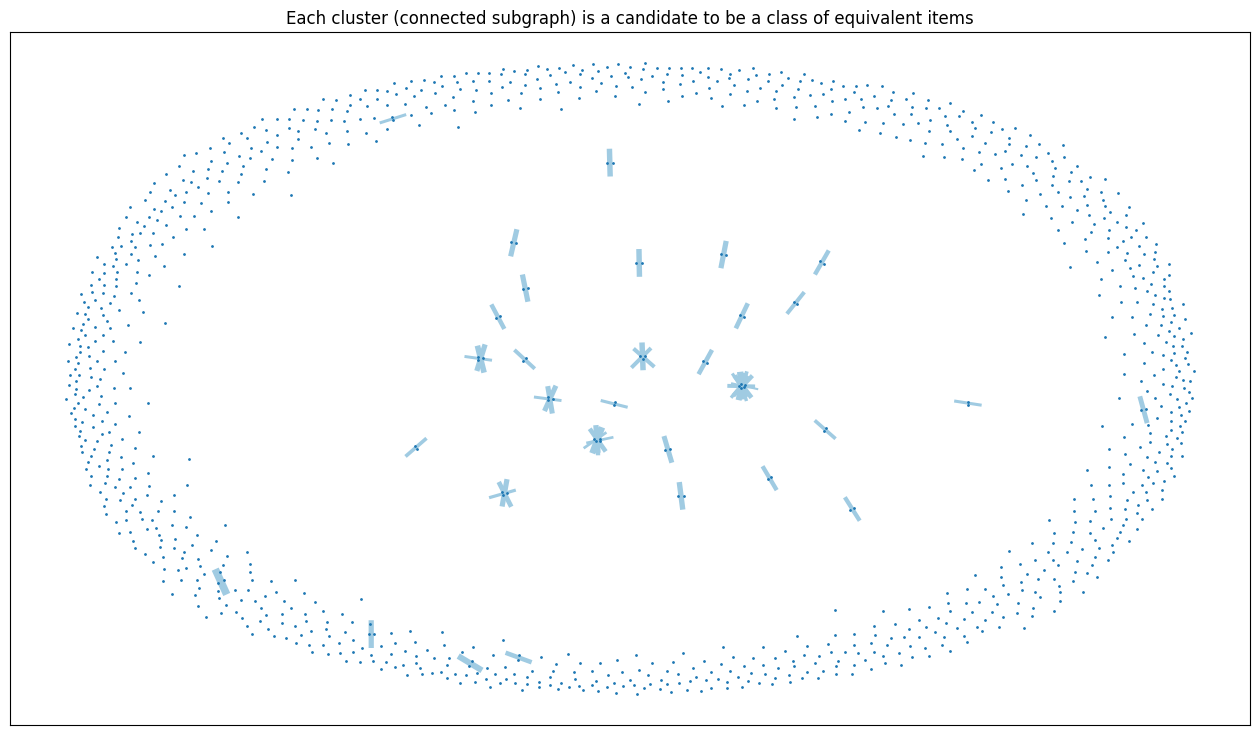

In [12]:
G = cat_distance_graphs[31]

plt.figure(figsize=(16, 9))
plt.title("Each cluster (connected subgraph) is a candidate to be a class of equivalent items")

nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=False, node_size=1, width=20, edge_color="#A0CBE2")

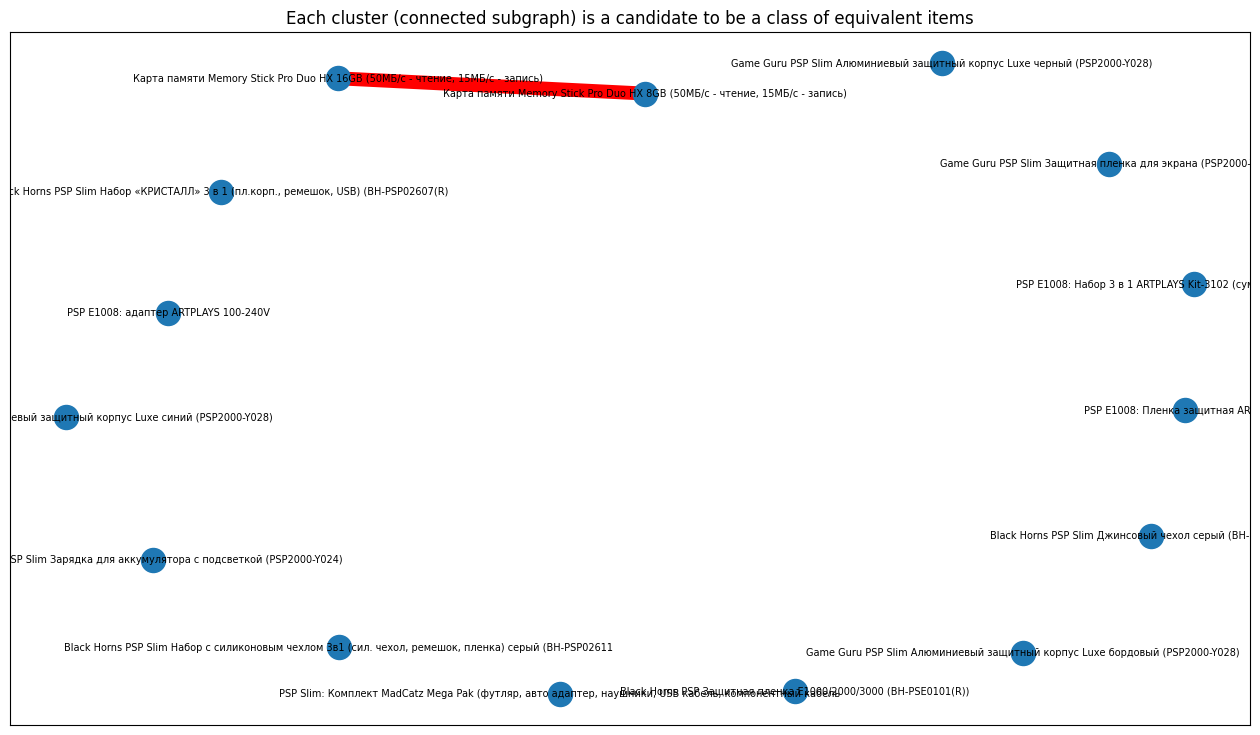

In [13]:
G = nx.Graph(cat_distance_graphs[4])

plt.figure(figsize=(16, 9))
plt.title("Each cluster (connected subgraph) is a candidate to be a class of equivalent items")

nx.draw_networkx(G, nx.spring_layout(G, k=5), with_labels=True, width=10, edge_color="#FF0000", font_size=7)

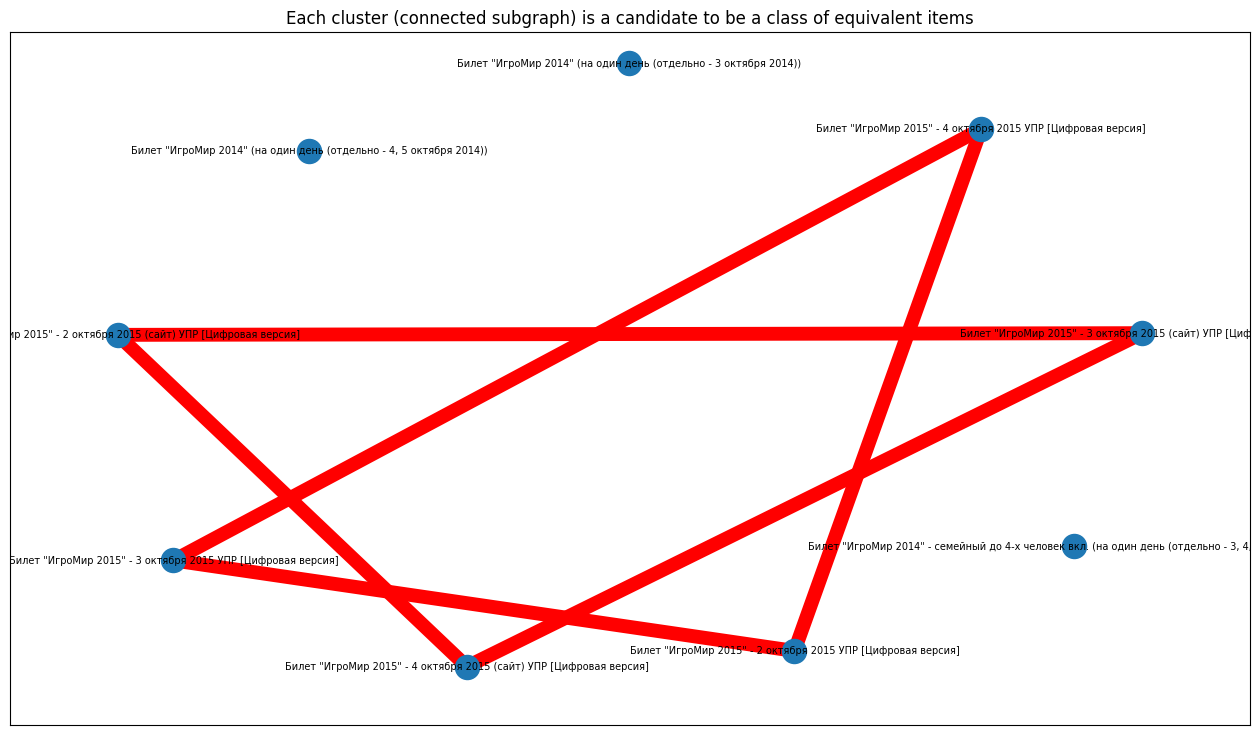

In [14]:
G = nx.Graph(cat_distance_graphs[8])

plt.figure(figsize=(16, 9))
plt.title("Each cluster (connected subgraph) is a candidate to be a class of equivalent items")

nx.draw_networkx(G, nx.spring_layout(G, k=5), with_labels=True, width=10, edge_color="#FF0000", font_size=7)

### Shop analisys

In [15]:
print(relations["shops"]["shop_name"])

0                       !Якутск Орджоникидзе, 56 фран
1                       !Якутск ТЦ "Центральный" фран
2                                    Адыгея ТЦ "Мега"
3                      Балашиха ТРК "Октябрь-Киномир"
4                            Волжский ТЦ "Волга Молл"
5                              Вологда ТРЦ "Мармелад"
6                          Воронеж (Плехановская, 13)
7                              Воронеж ТРЦ "Максимир"
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
10                         Жуковский ул. Чкалова 39м?
11                         Жуковский ул. Чкалова 39м²
12                                Интернет-магазин ЧС
13                                Казань ТЦ "Бехетле"
14                            Казань ТЦ "ПаркХаус" II
15                               Калуга ТРЦ "XXI век"
16                                   Коломна ТЦ "Рио"
17                      Красноярск ТЦ "Взлетка Плаза"
18                          

Looks like pairs :
* 0, 57
* 1, 58
* 10, 11
* 39, 40

are same shops but with different data.

Also we can add new city feature using shop_name string

In [16]:
print("0 - 57")
print(relations['sales_train'][relations['sales_train']["shop_id"] == 57].head(3))
print(relations['sales_train'][relations['sales_train']["shop_id"] == 0].head(3))

0 - 57
              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
259653  09.03.2013               2       57     4164       999.0           1.0
259654  06.03.2013               2       57     4164       999.0           1.0
259655  29.03.2013               2       57     4163      1590.0           2.0
             date  date_block_num  shop_id  item_id  item_price  item_cnt_day
37589  12.01.2013               0        0    11059        73.0           1.0
37590  22.01.2013               0        0    11059        73.0           1.0
37591  26.01.2013               0        0    11059        73.0           1.0


## ETL:
1. Extract the data from the source systems
2. Transform the data to meet the target schema and requirements
3. Load the transformed data into the target system
4. Validate the data after loading to ensure accuracy and completeness
5. Monitor the ETL process for errors and performance issues

In [36]:
shop_id_map = {
    0: 57,
    1: 58,
    11:10,
    39:40
}

regex =re.compile(r'[^\w\s]+')

map_pipes = {
    "sales_train": [
        lambda df: df.replace({"shop_id": shop_id_map}),
        lambda df: df.replace({"item_id": ids_to_id})
    ],
    "shops": [
        lambda df: df.replace({"shop_id": shop_id_map}),
        lambda df: df.assign(city = df["shop_name"].str.split(" ").str[0]),
    ],
    "items": [
            lambda df: df.assign(item_name = df["item_name"].apply(lambda x: x.lower())),
            lambda df: df.assign(item_name = [regex.sub('',x) for x in items['item_name'].tolist()]),
            lambda df: df.replace({"item_id": ids_to_id})
        ],
}

# this is test pipe to be redo
filter_pipes = {
        "sales_train": [
            lambda df: df[(0 < df["item_price"]) & (df["item_price"]  <= 60000)],
            lambda df: df[(0 <= df["item_cnt_day"]) & (df["item_cnt_day"] <= 4.0)],
            lambda df: df[~df.duplicated(keep="first")],
        ],
    }


transform = RelationsTransform(map_pipes, filter_pipes)
etl = ETL(transform)
train, test = etl.load()


In [41]:
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""


In [42]:
test.head(3)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад"""
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
